---

In [1]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/home/twhit/smc_object_detection/")
from utils.misc import select_cuda_device
from smc.prior import M71Prior
from smc.images import M71ImageModel
from smc.aggregate import Aggregate

device = select_cuda_device()

Selected device 0, which has 10822 MB available.


### Load in ground truth and SMC results

In [2]:
num_batches = len(glob.glob("smc/counts_*.pt"))
batch_size = 10
num_images = num_batches * batch_size

prior_max_objects = 6
num_catalogs_per_count = 10000
num_catalogs = num_catalogs_per_count * (prior_max_objects + 1)

tiles = torch.load('../data/tiles.pt')[:num_images]
counts = torch.load('../data/counts_magcut.pt')[:num_images]
locs = torch.load('../data/locs_magcut.pt')[:num_images]
fluxes = torch.load('../data/fluxes_magcut.pt')[:num_images]

smc_unpruned_counts = torch.zeros([num_batches, batch_size, num_catalogs])
smc_unpruned_locs = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects, 2])
smc_unpruned_fluxes = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects])
smc_posterior_predictive_total_flux = torch.zeros([num_batches, batch_size, num_catalogs])
smc_runtime = torch.zeros([num_batches, batch_size])
smc_num_iters = torch.zeros([num_batches, batch_size])

for b in range(num_batches):
    smc_unpruned_counts[b] = torch.load(f'smc/counts_{b}.pt')
    smc_unpruned_locs[b] = torch.load(f'smc/locs_{b}.pt')
    smc_unpruned_fluxes[b] = torch.load(f'smc/fluxes_{b}.pt')
    smc_posterior_predictive_total_flux[b] = torch.load(f'smc/posterior_predictive_total_flux_{b}.pt')
    smc_runtime[b] = torch.load(f'smc/runtime_{b}.pt')
    smc_num_iters[b] = torch.load(f'smc/num_iters_{b}.pt')

smc_unpruned_counts = smc_unpruned_counts.flatten(0,1)
smc_unpruned_locs = smc_unpruned_locs.flatten(0,1)
smc_unpruned_fluxes = smc_unpruned_fluxes.flatten(0,1)
smc_posterior_predictive_total_flux = smc_posterior_predictive_total_flux.flatten(0,1)
smc_runtime = smc_runtime.flatten(0,1)
smc_num_iters = smc_num_iters.flatten(0,1)

In [3]:
tile_dim = tiles.shape[-1]
pad = 2

In [4]:
smc_mask = torch.logical_and(smc_unpruned_locs > 0, smc_unpruned_locs < tiles.shape[-1]).all(-1)
smc_pruned_counts = smc_mask.sum(-1)

smc_pruned_locs = smc_mask.unsqueeze(-1) * smc_unpruned_locs
smc_locs_mask = (smc_pruned_locs != 0).int()
smc_locs_index = torch.sort(smc_locs_mask, dim=-2, descending=True)[1]
smc_pruned_locs = torch.gather(smc_pruned_locs, dim=-2, index=smc_locs_index)

smc_pruned_fluxes = smc_mask * smc_unpruned_fluxes
smc_fluxes_mask = (smc_pruned_fluxes != 0).int()
smc_fluxes_index = torch.sort(smc_fluxes_mask, dim=-1, descending=True)[1]
smc_pruned_fluxes = torch.gather(smc_pruned_fluxes, dim=-1, index=smc_fluxes_index)

### Load in SEP results

In [ ]:
sep_unpruned_counts = torch.load('sep/counts.pt')[:num_images]
sep_unpruned_locs = torch.load('sep/locs.pt')[:num_images]
sep_unpruned_fluxes = torch.load('sep/fluxes.pt')[:num_images]
sep_runtime = torch.load('sep/runtime.pt')[:num_images]

In [ ]:
sep_mask = torch.logical_and(sep_unpruned_locs > 0, sep_unpruned_locs < tiles.shape[-1]).all(-1)
sep_pruned_counts = sep_mask.sum(-1)

sep_pruned_locs = sep_mask.unsqueeze(-1) * sep_unpruned_locs
sep_locs_mask = (sep_pruned_locs != 0).int()
sep_locs_index = torch.sort(sep_locs_mask, dim=-2, descending=True)[1]
sep_pruned_locs = torch.gather(sep_pruned_locs, dim=-2, index=sep_locs_index)

sep_pruned_fluxes = sep_mask * sep_unpruned_fluxes
sep_fluxes_mask = (sep_pruned_fluxes != 0).int()
sep_fluxes_index = torch.sort(sep_fluxes_mask, dim=-1, descending=True)[1]
sep_pruned_fluxes = torch.gather(sep_pruned_fluxes, dim=-1, index=sep_fluxes_index)

### Plot attributes

In [6]:
smc_color = "steelblue"
sep_color = "mediumvioletred"

bigfont = 20
mediumfont = 16
smallfont = 14

cmap = 'gray'

linecolor = 'sienna'
linecolor_alt = 'forestgreen'
linewidth = 4
linestyle = 'dashed'

star_marker = '*'
star_fill = 'gold'
star_edge = 'black'
star_size = 400

---

### Figure 1: An example image and catalog

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# choose an image with the maximum source count, including at least two stars in the padded region
img_idx = torch.where(torch.logical_and(unpruned_counts - pruned_counts > 1,
                                        unpruned_counts == unpruned_counts.max()))[0][4]

smc_cat_idx = torch.where(smc_unpruned_counts[img_idx] == unpruned_counts[img_idx] - 1)[0][0]

_ = ax.imshow(images[img_idx], cmap = cmap)

_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

epsilon_pad = pad + 0.15 # thick lines make padding appear smaller than it is

_ = ax.hlines(y = [0 - epsilon_pad - 0.5, tile_dim + epsilon_pad - 0.5],
              xmin = 0 - epsilon_pad - 0.5, xmax = tile_dim + epsilon_pad - 0.5,
              color = linecolor, linestyles = 'dotted', linewidth = linewidth, zorder = 0)
_ = ax.vlines(x = [0 - epsilon_pad - 0.5, tile_dim + epsilon_pad - 0.5],
              ymin = 0 - epsilon_pad - 0.5 - 0.05, ymax = tile_dim + epsilon_pad - 0.5 + 0.05,
              color = linecolor, linestyles = 'dotted', linewidth = linewidth, zorder = 0)

_ = ax.hlines(y = [0 - 0.5, tile_dim - 0.5],
              xmin = 0 - 0.5, xmax = tile_dim - 0.5,
              color = linecolor_alt, linestyles = linestyle, linewidth = linewidth, zorder = 0)
_ = ax.vlines(x = [0 - 0.5, tile_dim - 0.5],
              ymin = 0 - 0.5 - 0.05, ymax = tile_dim - 0.5 + 0.05,
              color = linecolor_alt, linestyles = linestyle, linewidth = linewidth, zorder = 0)

_ = ax.scatter(unpruned_locs[img_idx, :unpruned_counts[img_idx], 1] - 0.5,
               unpruned_locs[img_idx, :unpruned_counts[img_idx], 0] - 0.5,
               color = star_fill, edgecolors = star_edge, marker = star_marker, s = star_size, zorder = 1)

_ = ax.scatter(smc_unpruned_locs[img_idx, smc_cat_idx, :smc_unpruned_counts[img_idx,smc_cat_idx].int(), 1] - 0.5,
               smc_unpruned_locs[img_idx, smc_cat_idx, :smc_unpruned_counts[img_idx,smc_cat_idx].int(), 0] - 0.5,
               color = smc_color, edgecolors = star_edge, marker = star_marker, s = star_size, zorder = 1)

fig.tight_layout()

fig.savefig('figures/figure1.png', dpi = 250, transparent = True)

---

### Figure 3: Estimated counts

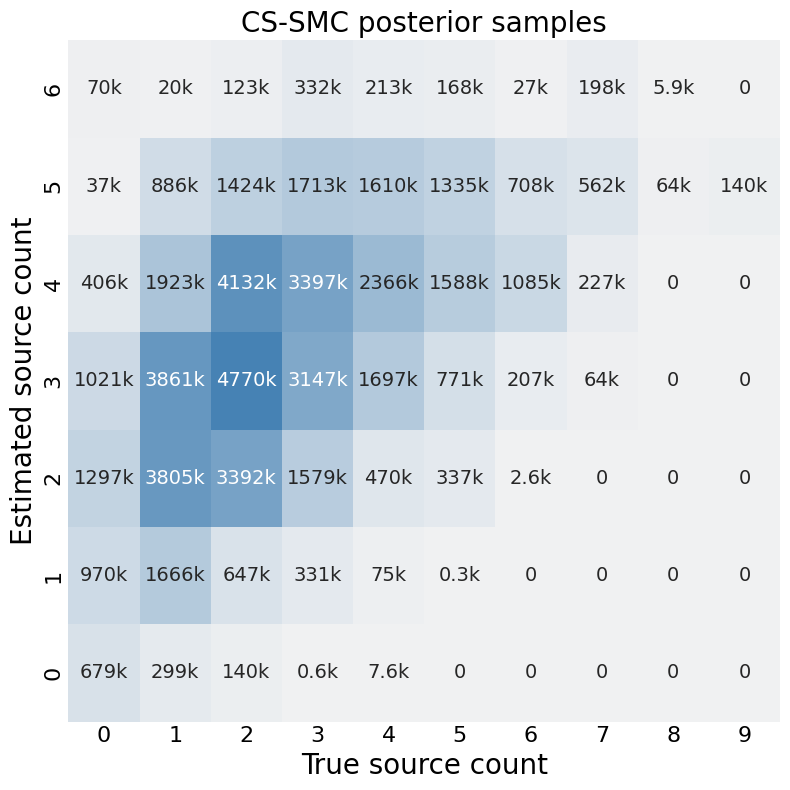

In [7]:
# Figure 3a
torch.manual_seed(0)

smc_sampled_counts = smc_pruned_counts
true_counts = counts.unsqueeze(-1).repeat(1, smc_pruned_counts.shape[-1])

smc_samples_confmat = torch.histogramdd(
    torch.stack((smc_sampled_counts,
                 true_counts),
                dim=-1).float(),
    bins = (torch.arange(0, smc_pruned_counts.max() + 2).float(), torch.arange(0, counts.max() + 2).unique().float())
).hist

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
fig3a = sns.heatmap(smc_samples_confmat.int().numpy(),
                    ax = ax, annot = True, annot_kws={"size": smallfont}, fmt = "d",
                    cmap = sns.light_palette(smc_color, as_cmap=True), cbar = False)
fig3a.invert_yaxis()

# Custom function to format the annotations
def format_func(value, tick_position):
    if value >= 100000:
        return f"{round(value / 1000, 1):.0f}k"
    if value >= 50:
        return f"{round(value / 1000, 1):.2g}k"
    return str("0")

# Apply the custom formatter to the annotations
for text in fig3a.texts:
    value = int(text.get_text())  # Get the annotation value
    text.set_text(format_func(value, None))  # Set the formatted annotation


fig3a.set_xlabel("True source count", fontsize = bigfont)
fig3a.set_ylabel("Estimated source count", fontsize = bigfont)
fig3a.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("CS-SMC posterior samples", fontsize = bigfont)

fig.tight_layout()

# fig.savefig('figures/figure3a.png', dpi = 250, transparent = True)

In [ ]:
# confusion matrix asymmetry factors
fig, ax = plt.subplots(1, 1, figsize = (6, 6 * (smc_pruned_counts.max() + 1) / (counts.max() + 1)))

rows, cols = torch.meshgrid(torch.arange(smc_samples_confmat.shape[0]), torch.arange(smc_samples_confmat.shape[1]), indexing='ij')
mask = torch.abs(rows - cols) <= 2

confmat = smc_samples_confmat.clone()
confmat[~mask] = torch.nan
confmat_t = confmat.transpose(0,1)

asymmetry_factors = ((confmat - confmat_t) / (torch.min(confmat, confmat_t) + 1))

panel = sns.heatmap(asymmetry_factors.abs().numpy(), vmin = 0, vmax = 1,
                    ax = ax, annot = asymmetry_factors.numpy(), annot_kws={"size": smallfont}, fmt = ".2f",
                    cmap = sns.light_palette(smc_color, as_cmap=True), cbar = False)
panel.invert_yaxis()

panel.set_xlabel("True source count", fontsize = bigfont)
panel.set_ylabel("Estimated source count", fontsize = bigfont)
panel.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("CS-SMC posterior samples", fontsize = bigfont)

fig.tight_layout()

In [ ]:
# Figure 3b
smc_mode_confmat = torch.histogramdd(
    torch.stack((smc_pruned_counts.mode(-1).values,
                 counts),
                dim=-1).float(),
    bins = (torch.arange(0, smc_pruned_counts.max() + 2).float(), torch.arange(0, counts.max() + 2).unique().float())
).hist

fig, ax = plt.subplots(1, 1, figsize = (6, 6 * (smc_pruned_counts.max() + 1) / (counts.max() + 1)))
fig3b = sns.heatmap(smc_mode_confmat.int().numpy(),
                    ax = ax, annot = True, annot_kws={"size": smallfont}, fmt = "d",
                    cmap = sns.light_palette(smc_color, as_cmap=True), cbar = False)
fig3b.invert_yaxis()

fig3b.set_xlabel("True source count", fontsize = bigfont)
fig3b.set_ylabel("Estimated source count", fontsize = bigfont)
fig3b.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("CS-SMC posterior mode", fontsize = bigfont)

fig.tight_layout()

# fig.savefig('figures/figure3b.png', dpi = 250, transparent = True)

In [ ]:
# Figure 3c
sep_confmat = torch.histogramdd(
    torch.stack((sep_pruned_counts, counts), dim=-1).float(),
    bins = (torch.arange(0, smc_pruned_counts.max() + 2).float(), torch.arange(0, counts.max() + 2).unique().float())
).hist

fig, ax = plt.subplots(1, 1, figsize = (6, 6 * (smc_pruned_counts.max() + 1) / (counts.max() + 1)))
fig3c = sns.heatmap(sep_confmat.int().numpy(),
                    ax = ax, annot = True, annot_kws={"size": smallfont}, fmt = "d",
                    cmap = sns.light_palette(sep_color, as_cmap=True), cbar = False)
fig3c.invert_yaxis()

fig3c.set_xlabel("True source count", fontsize = bigfont)
fig3c.set_ylabel("Estimated source count", fontsize = bigfont)
fig3c.tick_params(axis = 'both', length = 0, labelsize = mediumfont)

_ = ax.set_title("Source Extractor", fontsize = bigfont)

fig.tight_layout()

# fig.savefig('figures/figure3c.png', dpi = 250, transparent = True)

---

### Figure 4: Estimated total intrinsic flux

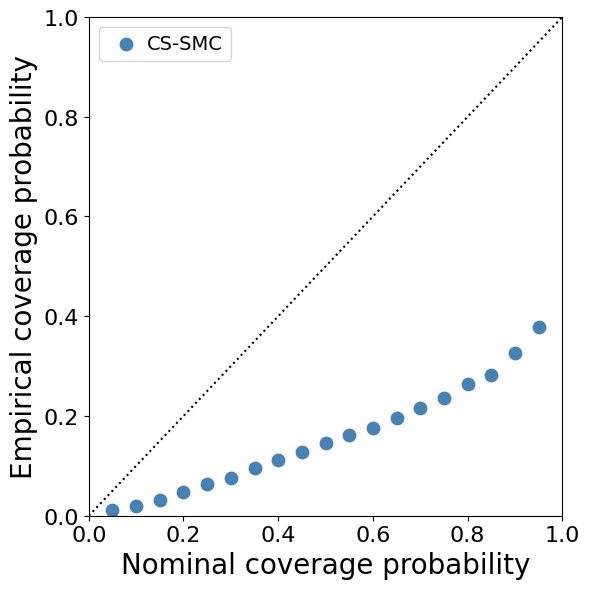

In [8]:
intervals = [c*0.05 for c in range(1,20)]
mh_coverage_rate = []

smc_masked_tif = smc_pruned_fluxes[counts>0].sum(-1)
masked_tif = fluxes[counts>0].sum(-1)

for i in intervals:
    qlow = smc_masked_tif.quantile(0.5 - i / 2, dim = -1)
    qhigh = smc_masked_tif.quantile(0.5 + i / 2, dim = -1)
    covered = torch.logical_and(qlow <= masked_tif, qhigh >= masked_tif)
    
    mh_coverage_rate.append(covered.float().mean())

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = ax.axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)
_ = ax.scatter(intervals, mh_coverage_rate, label = 'CS-SMC',
               color = smc_color, s = 80, zorder = 1)

_ = ax.set_xlim((0,1))
_ = ax.set_ylim((0,1))

_ = ax.set_xlabel('Nominal coverage probability', fontsize = bigfont)
_ = ax.set_ylabel('Empirical coverage probability', fontsize = bigfont)

_ = ax.tick_params(axis = 'both', labelsize = mediumfont)

_ = ax.legend(loc = 'upper left', prop = {'size': smallfont}, handletextpad = 0.1)

fig.tight_layout()

# fig.savefig('figures/figure4a.png', dpi = 250, transparent = True)

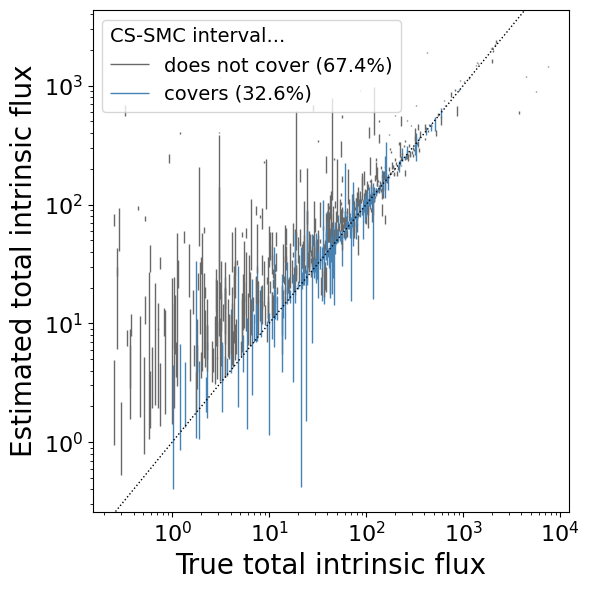

In [9]:
interval = 0.9

mask = torch.logical_and((fluxes.sum(-1) > 0) * (fluxes.sum(-1) < 10000),
                         smc_pruned_fluxes.sum(-1).quantile(0.01, dim=-1) > 0)

q05 = smc_pruned_fluxes[mask].sum(-1).quantile(0.5 - interval / 2, dim = -1)
q95 = smc_pruned_fluxes[mask].sum(-1).quantile(0.5 + interval / 2, dim = -1)
covered = torch.logical_and(q05 <= fluxes[mask].sum(-1),
                            q95 >= fluxes[mask].sum(-1))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

true_total_intrinsic_flux = fluxes[mask].sum(-1)

covered_legend = False
uncovered_legend = False
# to avoid one color from dominating, plot by index instead of in two groups
for i in range(fluxes[mask].shape[0]):
    color = smc_color if covered[i] else 'dimgray'
    if (covered[i]) and (not covered_legend):
        covered_legend = True
        _ = ax.vlines(x = true_total_intrinsic_flux[i],
                      ymin = q05[i], ymax = q95[i], color = color, alpha = 1, linewidth = 1,
                      label = f"covers ({round(100 * mh_coverage_rate[-2].item(), 1)}%)")
    elif (not covered[i]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax.vlines(x = true_total_intrinsic_flux[i],
                      ymin = q05[i], ymax = q95[i], color = color, alpha = 1, linewidth = 1,
                      label = f"does not cover ({round(100 * (1 - mh_coverage_rate[-2]).item(), 1)}%)")
    else:
        _ = ax.vlines(x = true_total_intrinsic_flux[i],
                    ymin = q05[i], ymax = q95[i], color = color, alpha = 1, linewidth = 1)

_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('True total intrinsic flux', fontsize = bigfont)
_ = ax.set_ylabel('Estimated total intrinsic flux', fontsize = bigfont)
# _ = ax.set_xlim(0.95*fluxes[mask].sum(-1).min(), fluxes[mask].sum(-1).max())
# _ = ax.set_ylim(0.95*sep_pruned_fluxes[mask].sum(-1).min(), 1.05*sep_pruned_fluxes[mask].sum(-1).max())
_ = ax.tick_params(axis = "both", labelsize = mediumfont)

leg = ax.legend(loc = 'upper left', prop = {'size': smallfont}, title = "CS-SMC interval...", title_fontsize = smallfont)
leg._legend_box.align = 'left'

fig.tight_layout()

# fig.savefig('figures/figure4b.png', dpi = 250, transparent = True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# to avoid one color from dominating, plot by index instead of in two groups
_ = ax.scatter(x = fluxes[mask].sum(-1), y = sep_pruned_fluxes[mask].sum(-1),
               color = sep_color, s = 5, alpha = 1, label = "Source Extractor")

_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('True total intrinsic flux', fontsize = bigfont)
_ = ax.set_ylabel('Estimated total intrinsic flux', fontsize = bigfont)
_ = ax.set_xlim(0.95*fluxes[mask].sum(-1).min(), fluxes[mask].sum(-1).max())
_ = ax.set_ylim(0.95*sep_pruned_fluxes[mask].sum(-1).min(), 1.05*sep_pruned_fluxes[mask].sum(-1).max())
_ = ax.tick_params(axis = "both", labelsize = mediumfont)
_ = ax.legend(loc = 'upper left', prop = {'size': smallfont},
              handletextpad = 0.1, markerscale = 2)

fig.tight_layout()

# fig.savefig('figures/figure4c.png', dpi = 250, transparent = True)

In [ ]:
# simulation-based calibration plot
sbc_mh_totalfluxes = (masked_tif.unsqueeze(-1) <= smc_masked_tif).float().mean(-1)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
_ = ax.hist(sbc_mh_totalfluxes, bins = 10, density = True)

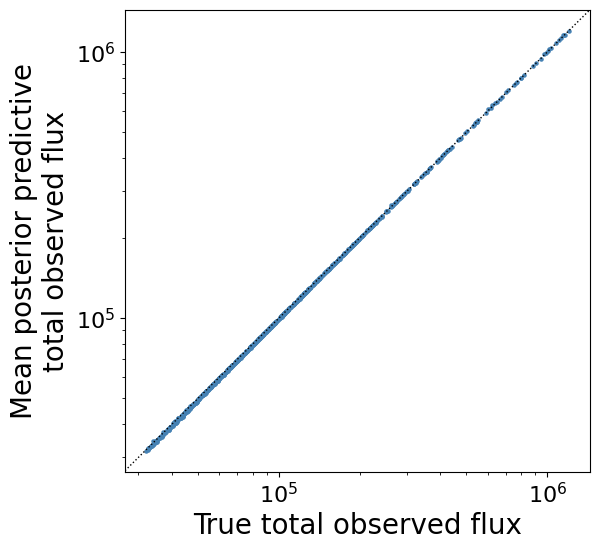

In [10]:
# true total observed flux vs mean posterior predictive total observed flux
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

posterior_predictive_mask = tiles.sum([-1,-2]) < tiles.sum([-1,-2]).quantile(0.99)

_ = ax.scatter(x = tiles[posterior_predictive_mask].sum([-1,-2]),
               y = smc_posterior_predictive_total_flux[posterior_predictive_mask].mean(-1),
               color = smc_color, s = 5, alpha = 1, label = "CS-SMC")

_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

_ = ax.set_xlabel('True total observed flux', fontsize = bigfont)
_ = ax.set_ylabel('Mean posterior predictive\ntotal observed flux', fontsize = bigfont)
_ = ax.tick_params(axis = 'both', labelsize = mediumfont)

---

### Figure 5: Estimated locations

In [ ]:
def plot_detections(image_index, ylabel, title = True, ylabel_fontsize = bigfont, figsize = (18, 6)):
    fig, ax = plt.subplots(1, 3, figsize = figsize, constrained_layout = True)

    # true catalog
    img = ax[0].imshow(tiles[image_index], cmap = cmap)
    if title:
        _ = ax[0].set_title("True catalog", fontsize = ylabel_fontsize)
    else:
        _ = ax[0].set_title("", fontsize = ylabel_fontsize)
    _ = ax[0].set_ylabel(ylabel, fontsize = ylabel_fontsize)
    _ = ax[0].scatter(locs[image_index, :counts[image_index].int().item(), 1] - 0.5,
                    locs[image_index, :counts[image_index].int().item(), 0] - 0.5,
                    color = star_fill, edgecolors = star_edge, marker = star_marker, s = star_size)
    _ = ax[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    _ = ax[0].set_xticks([])
    _ = ax[0].set_yticks([])
    _ = ax[0].hlines(y = [0 - pad - 0.5, tile_dim + pad - 0.5],
                xmin = 0 - pad - 0.5, xmax = tile_dim + pad - 0.5,
                color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    _ = ax[0].vlines(x = [0 - pad - 0.5, tile_dim + pad - 0.5],
                ymin = 0 - pad - 0.5, ymax = tile_dim + pad - 0.5,
                color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)

    # 10,000 smc catalogs
    _ = ax[1].imshow(tiles[image_index], cmap = cmap)
    if title:
        _ = ax[1].set_title("CS-SMC", fontsize = ylabel_fontsize)
    else:
        _ = ax[1].set_title("", fontsize = ylabel_fontsize)
    smc_catalog_idx = torch.randint(0, smc_unpruned_counts.shape[0], [10000])
    smc_locs_h = smc_unpruned_locs[image_index,smc_catalog_idx,:,1]
    smc_locs_w = smc_unpruned_locs[image_index,smc_catalog_idx,:,0]
    _ = ax[1].scatter(smc_locs_h[smc_locs_h.nonzero(as_tuple=True)] - 0.5,
                    smc_locs_w[smc_locs_w.nonzero(as_tuple=True)] - 0.5,
                    c =smc_pruned_fluxes[image_index,smc_catalog_idx], marker = star_marker, s = star_size, alpha = 0.1)
    _ = ax[1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    _ = ax[1].set_xticks([])
    _ = ax[1].set_yticks([])
    _ = ax[1].hlines(y = [0 - pad - 0.5, tile_dim + pad - 0.5],
                xmin = 0 - pad - 0.5, xmax = tile_dim + pad - 0.5,
                color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    _ = ax[1].vlines(x = [0 - pad - 0.5, tile_dim + pad - 0.5],
                ymin = 0 - pad - 0.5, ymax = tile_dim + pad - 0.5,
                color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)

    # sep catalog
    _ = ax[2].imshow(tiles[image_index], cmap = cmap)
    if title:
        _ = ax[2].set_title("Source Extractor", fontsize = ylabel_fontsize)
    else:
        _ = ax[2].set_title("", fontsize = ylabel_fontsize)
    _ = ax[2].scatter(sep_unpruned_locs[image_index, :sep_unpruned_counts[image_index].int().item(), 1] - 0.5,
                    sep_unpruned_locs[image_index, :sep_unpruned_counts[image_index].int().item(), 0] - 0.5,
                    color = sep_color, edgecolors = star_edge, marker = star_marker, s = star_size)
    _ = ax[2].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    _ = ax[2].set_xticks([])
    _ = ax[2].set_yticks([])
    _ = ax[2].hlines(y = [0 - pad - 0.5, tile_dim + pad - 0.5],
                xmin = 0 - pad - 0.5, xmax = tile_dim + pad - 0.5,
                color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    _ = ax[2].vlines(x = [0 - pad - 0.5, tile_dim + pad - 0.5],
                ymin = 0 - pad - 0.5, ymax = tile_dim + pad - 0.5,
                color = linecolor, linestyles = linestyle, linewidth = linewidth, alpha = 0)
    
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction = 0.014, pad = 0.02)
    cbar.ax.tick_params(labelsize = 0.75 * ylabel_fontsize)
    
    return fig

In [ ]:
torch.manual_seed(0)

image_indexes_2stars = torch.where(counts == 2)[0]
image_index = image_indexes_2stars[torch.randint(0, image_indexes_2stars.shape[0], [1])].item()

fig5a = plot_detections(image_index, "image 1")

# fig5a.savefig('figures/figure5a.png', dpi = 250, transparent = True)

In [ ]:
torch.manual_seed(0)

image_indexes_4stars = torch.where(counts == 4)[0]
image_index = image_indexes_4stars[torch.randint(0, image_indexes_4stars.shape[0], [1])].item()

fig5b = plot_detections(image_index, "image 2", title = False)

# fig5b.savefig('figures/figure5b.png', dpi = 250, transparent = True)

In [ ]:
torch.manual_seed(0)

image_indexes_6stars = torch.where(counts == 6)[0]
image_index = image_indexes_6stars[torch.randint(0, image_indexes_6stars.shape[0], [1])].item()

fig5c = plot_detections(image_index, "image 3", title = False)

# fig5c.savefig('figures/figure5c.png', dpi = 250, transparent = True)

---

### Additional figures: Runtime and number of SMC iterations

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

_ = ax[0].scatter(counts, smc_runtime, color = smc_color, alpha = 0.25)
_ = ax[0].set_xlabel("True source count", fontsize = bigfont)
_ = ax[0].set_ylabel("Runtime (seconds)", fontsize = bigfont)
_ = ax[0].tick_params(axis = "both", labelsize = mediumfont)

_ = ax[1].scatter(counts, smc_num_iters, color = smc_color, alpha = 0.25)
_ = ax[1].set_xlabel("True source count", fontsize = bigfont)
_ = ax[1].set_ylabel("Number of SMC sampler iterations", fontsize = bigfont)
_ = ax[1].tick_params(axis = "both", labelsize = mediumfont)

fig.tight_layout()

---